# Fireveg DB - plot of fire history per sampling location

Author: [José R. Ferrer-Paris](https://github.com/jrfep) and [Ada Sánchez-Mercado](https://github.com/adasanchez)

Date: July 2024

This Jupyter Notebook includes R code to visualise data from the Fireveg Database. 

The input is loaded from a public data record of the database.

Timing of field visits in relation to time since fire disaggregated by dataset.


## Set-up

### Load packages

In [1]:
library(ggplot2)
library(forcats)
library(dplyr)
library(data.table)
library(sf)
library(tidyr)
library(ozmaps)
library(ggrepel)
library(ggpubr)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


Linking to GEOS 3.11.0, GDAL 3.5.3, PROJ 9.1.0; sf_use_s2() is TRUE



### Paths for inputs and outputs

Set working directory

In [2]:
here::i_am("database-summary/Fire-history-field-visits.ipynb")

here() starts at /Users/z3529065/proyectos/fireveg/fireveg-analysis



In [ ]:
data_dir <- here::here("data")
if (!dir.exists(data_dir))
    dir.create(data_dir)

### Download data from OSF

In [3]:


for (RDSfile in here::here(data_dir,c("Quadrat-sample-data.rds","fire-history.rds", "site-visits.rds", "field-sites.gpkg"))) {
    if (file.exists(RDSfile)) {
        cat(sprintf("RDS file found at:\n%s\nNo need to download!\n\n", RDSfile))
    } else {
        require(osfr)
        osf_project <- osf_retrieve_node("https://osf.io/h96q2")
        file_list <- osf_ls_files(osf_project, pattern="Summary-traits-sources.rds")
        osf_download(file_list,
                 data_dir,
                 conflicts = "overwrite")
    }
}

RDS file found at:
/Users/z3529065/proyectos/fireveg/fireveg-analysis/data/Quadrat-sample-data.rds
No need to download!

RDS file found at:
/Users/z3529065/proyectos/fireveg/fireveg-analysis/data/fire-history.rds
No need to download!

RDS file found at:
/Users/z3529065/proyectos/fireveg/fireveg-analysis/data/site-visits.rds
No need to download!

RDS file found at:
/Users/z3529065/proyectos/fireveg/fireveg-analysis/data/field-sites.gpkg
No need to download!



### Read data from local folder

In [4]:
firehistory_table <- readRDS(here::here(data_dir,"fire-history.rds")) |> mutate(site_label=factor(site_label))
quadrats_table <- readRDS(here::here(data_dir,"Quadrat-sample-data.rds"))
visits_table <- readRDS(here::here(data_dir,"site-visits.rds"))
site_locs <- read_sf(here::here(data_dir,"field-sites.gpkg"))


## Visualisation of fire history

In [5]:
site_visit_firehistory <- 
  firehistory_table |> 
  group_by(site_label) |>
  summarise(nfires=n(),
            first_fire=min(earliest_date),
            date1=max(earliest_date),date2=max(latest_date)) |>
  left_join(visits_table, by="site_label", relationship = "one-to-many") |>
  mutate(
    time_min=visit_date-date2, 
    time_max=visit_date-date1,
    month1=month(date1),
    month2=month(date2)) |>
  filter(time_min >= 0,time_max < 1000, month1==month2)  

In [6]:
included <- c("Mallee Woodlands")
excluded <- c( "TO BE CLASSIFIED")
field_surveys <- site_locs |> 
         filter(!survey_name %in% excluded)

In [7]:
survey_cts <- field_surveys |> 
  group_by(survey_name,survey_description) |> 
  summarise(
    nsites=n(),
    geom=st_union(geom),.groups='keep') |> 
  st_centroid()
xys <- st_coordinates(survey_cts) |> data.frame()
xys$survey_name <- survey_cts$survey_name
xys$survey_desc <- survey_cts |> 
  transmute(
    description=sprintf(
      "%s\n%s sites",
      survey_description, nsites
      )) |>
  pull(description)


In [8]:
 fire_visits_data <- firehistory_table %>% 
  transmute(site_label,
    date = earliest_date,
    event = 'fire') |>
  bind_rows(
    visits_table |> 
      transmute(site_label,
      date = visit_date,
      event = 'visit')
    ) |>
  right_join(field_surveys |> st_drop_geometry(), 
             by="site_label", relationship="many-to-one") 



In [9]:
fire_visits_data <- fire_visits_data |> 
  filter((survey_name %in% "Mallee Woodlands" & date > "2000-01-01") | 
  (!(survey_name %in% "Mallee Woodlands") & date > "2015-01-01"))


In [10]:
tsf <- 
  fire_visits_data |> 
    pivot_wider(id_cols = c(survey_description, site_label), 
      names_from = event, 
      values_from = date, 
      values_fn = max) |>
    mutate(
      time_since_fire = visit - fire,
      legacy = if_else(
        survey_description %in% "Mallee Woodlands",
        "Western NSW",
        "Eastern NSW")
    )


Don't know how to automatically pick scale for object of type <difftime>.
Defaulting to continuous.
Warning message:
“Removed 26 rows containing non-finite outside the scale range (`stat_bin()`).”


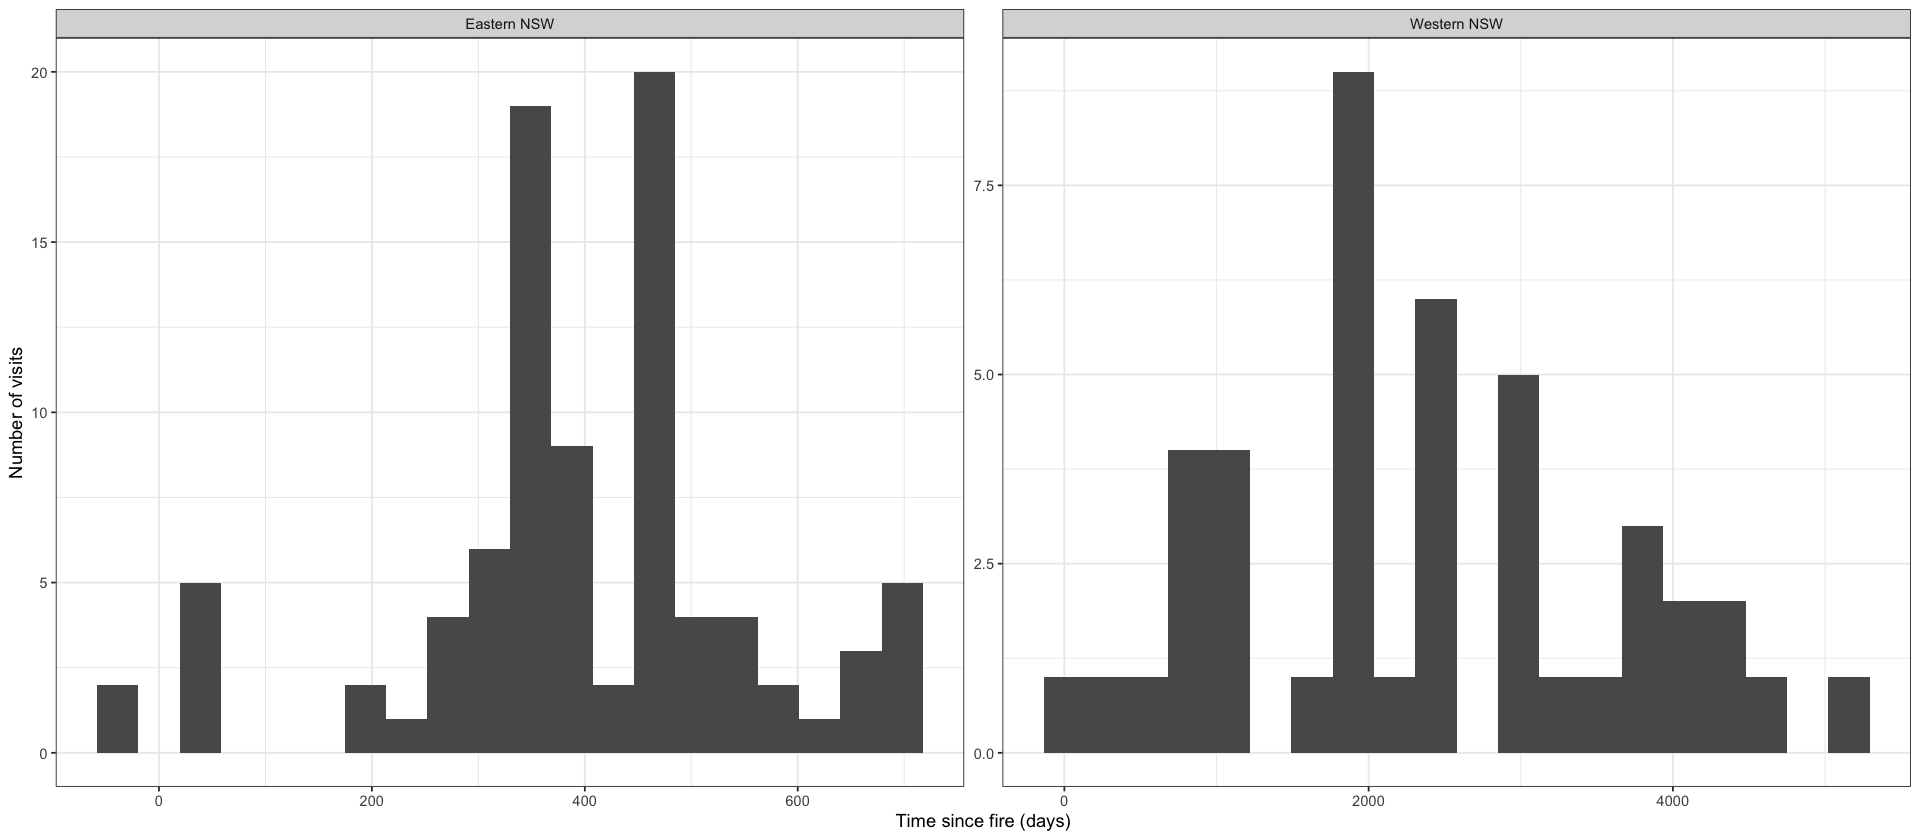

In [11]:
options(repr.plot.width=16) # Make plot larger

ggplot(tsf,
  aes(
    x = time_since_fire,
  )) +
  geom_histogram(bins = 20) +
  facet_wrap(~ legacy, scales ="free") +
  theme(legend.position = "none") +
  labs(x = "Time since fire (days)", y = "Number of visits") +
  theme_bw()

In [12]:
quadrats_table |> head()

,visit_id,visit_date,sample_nr,sample_method,quadrat_area,min_fire_date,max_fire_date,species,species_code,resprout_organ,⋯,adults_unburnt,resprouts_live,resprouts_died,resprouts_kill,resprouts_reproductive,recruits_live,recruits_died,recruits_reproductive,scorch,life_stage
,<chr>,<date>,<int>,<chr>,<dbl>,<date>,<date>,<chr>,<int>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
1,CRC09B7UVH,2021-02-03,1,NA,NA,2020-02-10,2020-02-10,Goodenia ovata,3192,NA,⋯,0,0,NA,NA,0,100,NA,0,NA,NA
2,CRC09B7UVH,2021-02-03,1,NA,NA,2020-02-10,2020-02-10,Gonocarpus tetragynus,3247,NA,⋯,0,100,NA,NA,0,0,NA,0,NA,NA
3,CRC09B7UVH,2021-02-03,1,NA,NA,2020-02-10,2020-02-10,Eucalyptus blaxlandii,4058,NA,⋯,0,0,NA,NA,0,16,NA,0,NA,NA
4,CRC09B7UVH,2021-02-03,1,NA,NA,2020-02-10,2020-02-10,Eucalyptus viminalis,4197,NA,⋯,0,0,NA,NA,0,1,NA,0,NA,NA
5,CRC09B7UVH,2021-02-03,1,NA,NA,2020-02-10,2020-02-10,Pteridium esculentum,6403,NA,⋯,0,32,NA,NA,0,0,NA,0,NA,NA
6,CRC09B7UVH,2021-02-03,1,NA,NA,2020-02-10,2020-02-10,Opercularia aspera,5697,None,⋯,0,0,NA,NA,0,4,NA,0,NA,NA


In [13]:
nsw <- st_transform(ozmaps::ozmap_states, 4326) %>% filter(NAME == "New South Wales")
okabe <- c("#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7")

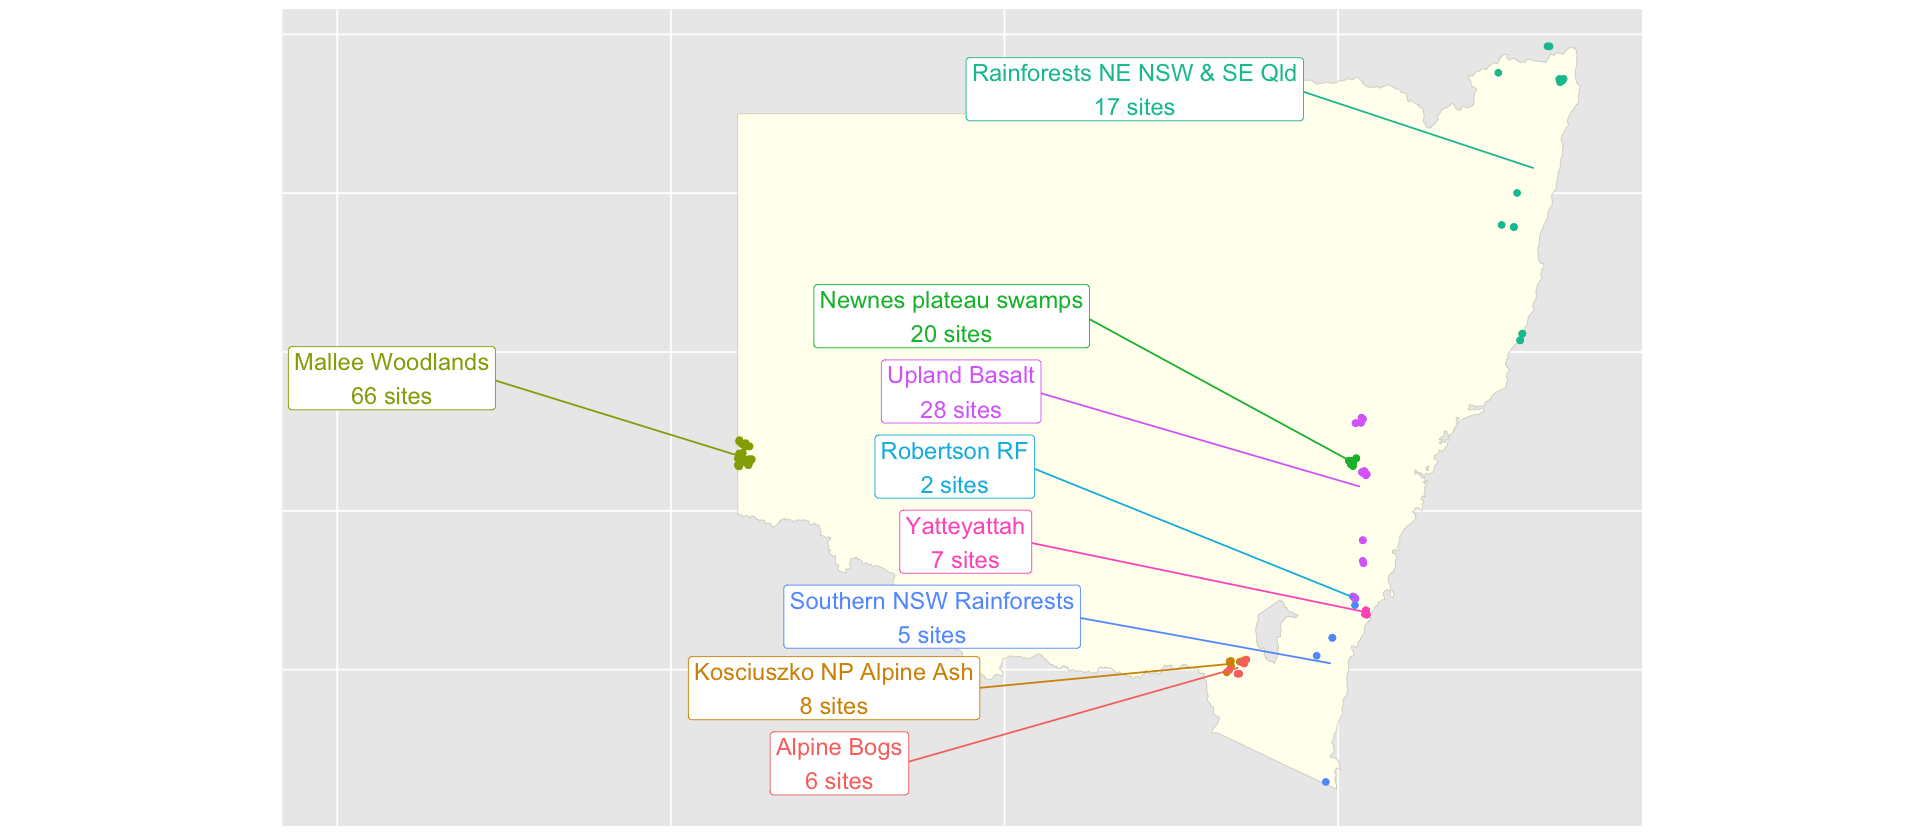

In [14]:
map1 <- ggplot() + 
    geom_sf(data=nsw,fill='ivory1',colour='ivory3') +
    geom_sf(data=field_surveys,aes(colour=survey_name)) + 
  geom_label_repel(data=xys,
                   size=5,
                   nudge_x = -6,
                   nudge_y = 1,
                   direction = "y",
                aes(label=survey_desc
                    , colour=survey_name,x=X,y=Y)) +
  #theme_bw() +
  theme(legend.position = "none",
        axis.title.x = element_blank(),
        axis.title.y = element_blank(),
        axis.text.x=element_blank(), #remove x axis labels
        axis.ticks.x=element_blank(), #remove x axis ticks
        axis.text.y=element_blank(),  #remove y axis labels
        axis.ticks.y=element_blank()  #remove y axis ticks
        )
map1

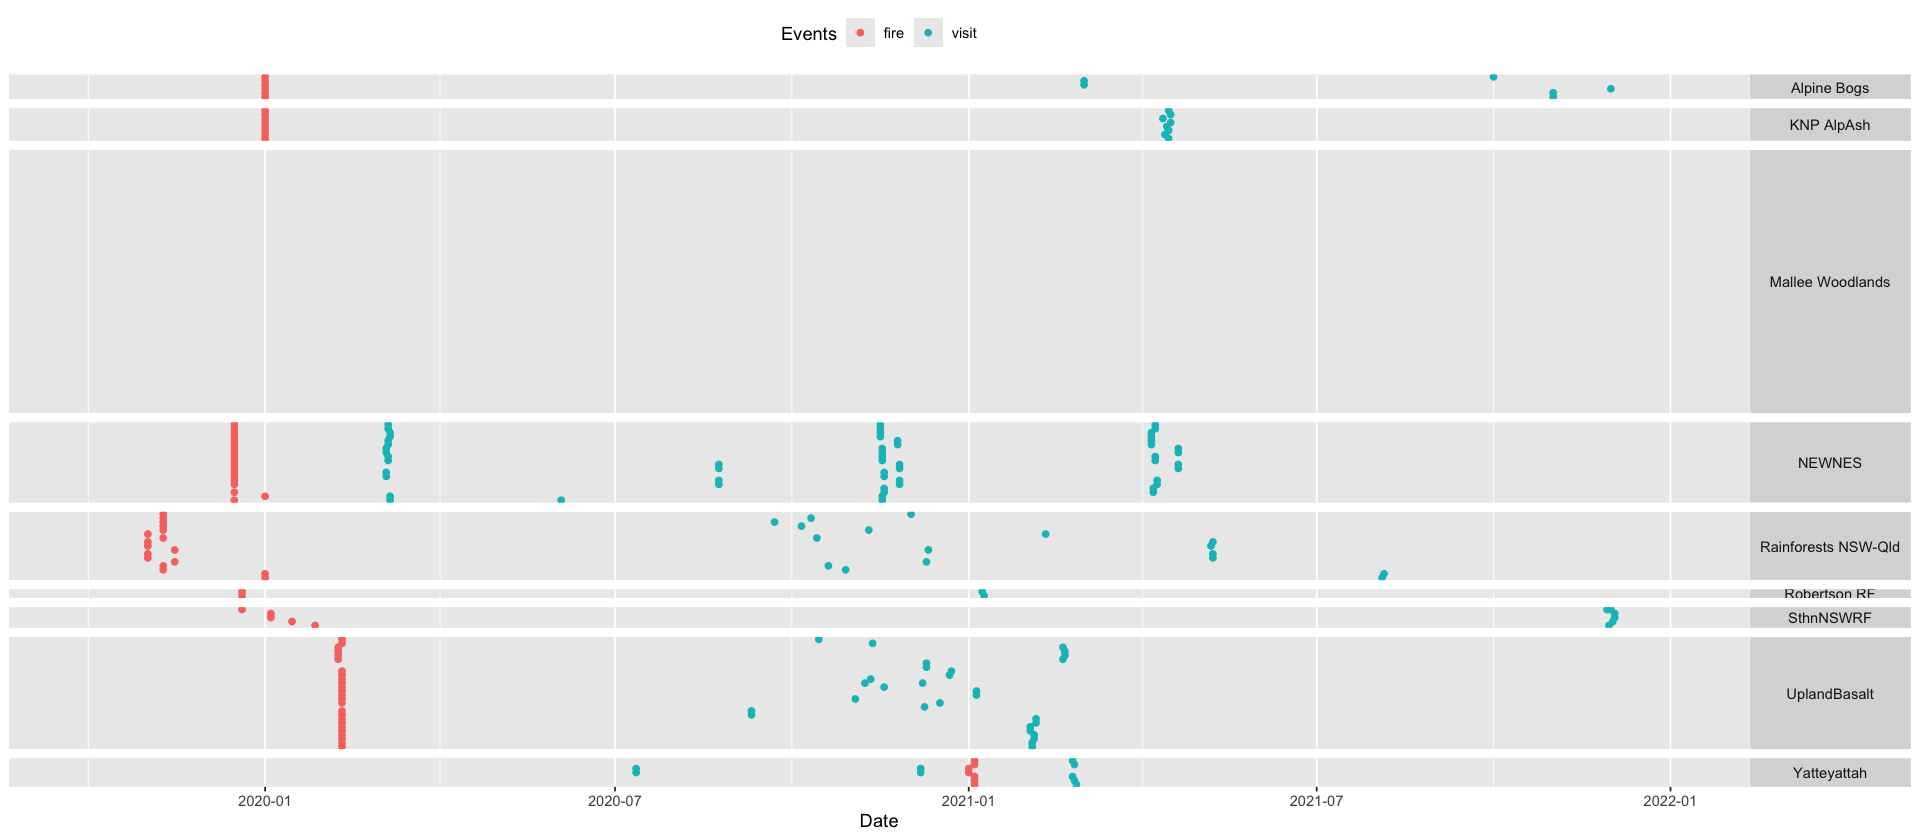

In [15]:


fire1 <- ggplot(fire_visits_data) + 
    geom_point(aes(x=date, y=site_label, colour=event)) +
  facet_grid(survey_name ~ ., scales="free", space="free") +
#  coord_polar(theta="y", start=0,direction=1) +
    coord_cartesian(xlim=as.Date(c('2019-10-01','2022-01-01'))) +
  #theme_linedraw() +
    labs(x = "Date", colour = "Events") +
  scale_y_discrete(breaks=NULL) +
  theme(legend.position = "top",
        panel.grid.minor.y = element_blank(),
        axis.title.y = element_blank(),
        axis.text.y = element_blank(), #remove x axis labels
        strip.text.y.right = element_text(angle = 0)
        )
fire1

In [16]:

ggarrange(fire1,fire2)

ERROR: Error in eval(expr, envir, enclos): object 'fire2' not found


In [ ]:
included <- c("Mallee Woodlands")
field_surveys <- site_locs %>% 
         filter(survey_name %in% included)
survey_cts <- field_surveys %>% 
  group_by(survey_name,survey_description) %>% 
  summarise(
    nsites=n(),
    geom=st_union(geom),.groups='keep') %>% 
  st_centroid 
xys <- st_coordinates(survey_cts) %>% data.frame()
xys$survey_name <- survey_cts$survey_name
xys$survey_desc <- survey_cts %>% 
  transmute(
    description=sprintf(
      "%s\n%s sites",
      survey_description, nsites
      )) %>%
  pull(description)
            

In [ ]:
                                 
map2 <- ggplot() + 
    geom_sf(data=nsw,fill='ivory1',colour='ivory3') +
    geom_sf(data=field_surveys,aes(colour=survey_name)) + 
  geom_label_repel(data=xys,
                   size=6,
                   nudge_x = 5,
                aes(label=survey_desc
                    , colour=survey_name,x=X,y=Y)) +
  #theme_minimal() +
  theme(legend.position = "none",
        axis.title.x = element_blank(),
        axis.title.y = element_blank(),
        axis.text.x=element_blank(), #remove x axis labels
        axis.ticks.x=element_blank(), #remove x axis ticks
        axis.text.y=element_blank(),  #remove y axis labels
        axis.ticks.y=element_blank()  #remove y axis ticks
        )

In [ ]:
fire_visits_data_Mallee <- firehistory_table %>% 
  transmute(site_label,date=earliest_date,event='fire') %>%
  bind_rows(
    visits_table %>% 
      transmute(site_label,date=visit_date,event='visit')
    ) %>% 
  right_join(field_surveys %>% st_drop_geometry, 
             by="site_label", relationship="many-to-one") %>%
  filter(
    date < '2019-01-01'
         )

fire2 <- ggplot(fire_visits_data) + 
    geom_point(aes(x=date, y=site_label, colour=event)) +
  facet_grid(survey_name ~ ., scales="free", space="free") +
#  coord_polar(theta="y", start=0,direction=1) +
    coord_cartesian(xlim=as.Date(c('2000-10-01','2019-01-01'))) +
  #theme_linedraw() +
    labs(x = "Date", colour = "Events") +
  scale_y_discrete(breaks=NULL) +
  theme(legend.position = "top",
        panel.grid.minor.y = element_blank(),
        axis.title.y = element_blank(),
        axis.text.y = element_blank(), #remove x axis labels
        strip.text.y.right = element_text(angle = 0)
        )